In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import re
import pickle
import sklearn
import sys
import string

from datetime import datetime
from scipy import stats

from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.delicious_t140
%aimport src.helpers.labels
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [14]:
from src.features.delicious_t140 import clean_text_delicious
from src.data.delicious_t140 import get_sample_from_cache
from src.helpers.labels import truncate_labels
from src.utils.metrics import ranking
from src.helpers.topics import get_word_weight_dict
from src.utils.dataframes import sample_rows
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/delicious-topics/")
DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140"
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/delicious-t140/")
OUTPUT_FILE = 'output-topic-words-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

# CONFIGS

SEED= 42

MAX_NB_WORDS = 500

# for sampling
MIN_TAG_DF = 10
SAMPLE_FRAC=20

# CONFIGS
NB_NEIGHBOURS = 1
DISTANCE_METRIC= lambda a,b: stats.entropy(a,b)
STOP_WORDS='english' # using stopwords since most people using LDA do this
NB_COMPONENTS = [50,100,200,300]

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = get_sample_from_cache(INTERIM_DATA_ROOT,SAMPLE_FRAC)

In [8]:
docs_df.head(1)

,filename,filetype,hash,tags,url,num_users,num_tags,contents
0,26313806abe42032de4f612017738426.html,html,26313806abe42032de4f612017738426,"tutoriel,multimedia,english,screencasts,videos...",http://screencasts.ubuntu.com/,228,23,"Ubuntu Screencasts @import ""/misc/drupal.css""..."


In [9]:
len(docs_df)

28743

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))
labels = truncate_labels(labels,MIN_TAG_DF)

In [11]:
np.random.seed(SEED)

mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['contents'].values
indices = np.arange(len(data))
np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 3305 
total number of train documents: 24432
total number of validation documents: 4311


In [12]:
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
vect.fit(data)

X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

In [13]:
%%time

lda = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    
    cache_path = INTERIM_DATA_ROOT+"/lda-NBCOMPS={}NBWORDS={}SEED={}.p".format(nb_comp,MAX_NB_WORDS,SEED)
    
    if os.path.isfile(cache_path):
        lda[nb_comp]=joblib.load(open(cache_path,"rb"))
    else:
        lda[nb_comp] = LatentDirichletAllocation(n_components=nb_comp, learning_method='online')
        lda[nb_comp].fit(X_train_vect)
        joblib.dump(lda[nb_comp],open(cache_path,"wb"))

nb_comp=50
nb_comp=100
nb_comp=200
nb_comp=300
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 7.02 ms


In [15]:
def train_and_score(nb_comp,results_dict):
    
    vocabulary = vect.get_feature_names()
    tag_vocabulary = mlb.classes_
    
    model = lda[nb_comp]
    
    X_train = model.transform(X_train_vect)
    X_val = model.transform(X_val_vect)
    
#     # training
    
#     Y_pred_train = []

#     for (i,test_document_topics_distr) in enumerate(X_train):
               
#         most_important_topic_index = np.argsort(test_document_topics_distr)[-1]    
            
#         # 'word' => weight in topic
#         word_weight_dict = get_word_weight_dict(model,most_important_topic_index,vocabulary)

#         # only keep words that are valid tags
#         valid_tag_elems = [(k,v) for (k,v) in word_weight_dict.items() if k in tag_vocabulary]

#         valid_word_weight_dict = dict(valid_tag_elems)
#         valid_words = valid_word_weight_dict.keys()

#         # make a dummy y_score out of that (the numbers aren't probabililties
#         # but we're only interested in the ranking, not absolute numbers)
#         y_scores_dummy = [valid_word_weight_dict[tag_value] if tag_value in valid_words else 0.0 for (tag_index,tag_value) in enumerate(tag_vocabulary)]

#         y_scores_dummy = np.array(y_scores_dummy)

#         Y_pred_train.append(y_scores_dummy)

#     Y_pred_train = np.array(Y_pred_train)
    
    # validation
    
    Y_pred_val = []

    # for every validation document do
    for (i,test_document_topics_distr) in enumerate(X_val):

        most_important_topic_index = np.argsort(test_document_topics_distr)[-1]
                
        # 'word' => weight in topic
        word_weight_dict = get_word_weight_dict(model,most_important_topic_index,vocabulary)

        # only keep words that are valid tags
        valid_tag_elems = [(k,v) for (k,v) in word_weight_dict.items() if k in tag_vocabulary]

        valid_word_weight_dict = dict(valid_tag_elems)
        valid_words = valid_word_weight_dict.keys()

        # make a dummy y_score out of that (the numbers aren't probabililties
        # but we're only interested in the ranking, not absolute numbers)
        y_scores_dummy = [valid_word_weight_dict[tag_value] if tag_value in valid_words else 0.0 for (tag_index,tag_value) in enumerate(tag_vocabulary)]

        y_scores_dummy = np.array(y_scores_dummy)

        Y_pred_val.append(y_scores_dummy)

    Y_pred_val = np.array(Y_pred_val)
    
    # scoring
    
    ks = [1,2,3,4,5,6,7,8,9,10]
    
    # k is the number of neighbors so let's use at_k
    results = list()
    for at_k in ks:
        result = ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True)
        results.append(result)
        print("validation micro-F1 @{}: {}".format(at_k,result)) 

    print('')  
    
    results_dict[nb_comp] = results

In [17]:
results = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    train_and_score(nb_comp,results)

nb_comp=50
validation micro-F1 @1: 0.025646897183421113
validation micro-F1 @2: 0.01587849499482223
validation micro-F1 @3: 0.013058841603933016
validation micro-F1 @4: 0.010154627279021463
validation micro-F1 @5: 0.01583283472177475
validation micro-F1 @6: 0.013821700069108501
validation micro-F1 @7: 0.013952416992990884
validation micro-F1 @8: 0.014336298471370584
validation micro-F1 @9: 0.021619967875991127
validation micro-F1 @10: 0.026189277047754225

nb_comp=100
validation micro-F1 @1: 0.007855822550831794
validation micro-F1 @2: 0.017475281673948035
validation micro-F1 @3: 0.013364055299539171
validation micro-F1 @4: 0.01256266927908719
validation micro-F1 @5: 0.01079734219269103
validation micro-F1 @6: 0.010154627279021463
validation micro-F1 @7: 0.024160282852091926
validation micro-F1 @8: 0.023610315186246417
validation micro-F1 @9: 0.024842823325782065
validation micro-F1 @10: 0.026505527707203186

nb_comp=200
validation micro-F1 @1: 0.03464782311374515
validation micro-F1 @

In [18]:
feats_50 = [
0.025646897183421113,
 0.01587849499482223,
0.013058841603933016,
 0.010154627279021463,
 0.01583283472177475,
 0.013821700069108501,
0.013952416992990884,
 0.014336298471370584,
0.021619967875991127,
 0.026189277047754225
]

feats_100 = [
 0.007855822550831794,
 0.017475281673948035,
 0.013364055299539171,
 0.01256266927908719,
0.01079734219269103,
0.010154627279021463,
 0.024160282852091926,
 0.023610315186246417,
0.024842823325782065,
0.026505527707203186
]

feats_200 = [
0.03464782311374515,
 0.027453671928620454,
0.019903544361938297,
0.017817115926202654,
0.0260989010989011,
0.026400122081489393,
0.025776062281246934,
0.029088207560648057,
0.029407283254609173,
0.03137201178162888    
]

feats_300 = [
0.03285420944558522,
0.01975195222783647,
0.01488871834228703,
0.027904849039341262,
0.030247646897560085,
0.027453671928620454,
0.026937788093759196,
0.02880658436213992,
0.02880658436213992,
 0.028896712541721915
]


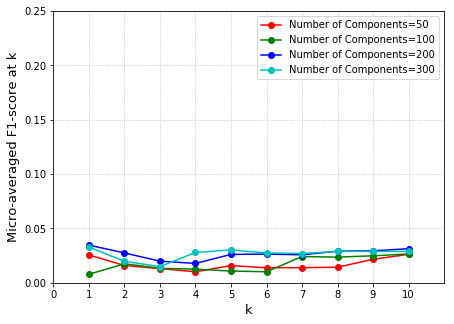

In [19]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)

ax.plot(ks, feats_50, 'ro-', label='Number of Components=50')

ax.plot(ks, feats_100, 'go-', label='Number of Components=100')

ax.plot(ks, feats_200, 'bo-', label='Number of Components=200')

ax.plot(ks, feats_300, 'co-', label='Number of Components=300')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.25)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 0.26, 0.05))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()